# Module 1: Time Series Forecasting: FTSE Closing Prices

**Objective:**
1. Explore different time series forecasting approaches (AR, RNN, LSTM)
2. Implement models using PyTorch
3. Compare model performance on FTSE data
4. Analyze which approach best predicts recent significant drop due to the recent trade war

**Data**: FTSE100 closing prices for last month  from Yahoo!

## Prerequisites

In [ ]:
# Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [ ]:
# Code for data downloading from git
import requests

def download_github_file(github_url: str, local_path: str) -> None:
    raw_url = github_url
    if "github.com" in github_url and "raw.githubusercontent.com" not in github_url:
        # From this: https://github.com/username/repo/blob/branch/path/to/file
        # To this: https://raw.githubusercontent.com/username/repo/branch/path/to/file
        parts = github_url.split('/')
        try:
            blob_index = parts.index('blob')
            username = parts[3]
            repo = parts[4]
            branch = parts[blob_index + 1]
            file_path = '/'.join(parts[blob_index + 2:])
            raw_url = f"https://raw.githubusercontent.com/{username}/{repo}/{branch}/{file_path}"
        except ValueError:
            pass

    try:
        response = requests.get(raw_url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Downloading error: {e}")
        return

    with open(local_path, "wb") as f:
        f.write(response.content)
    print("Saved: ", local_path)


In [ ]:
# Helper sequence function:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
# Plot training loss
def plot_loss(train_losses, title):
    plt.figure(figsize=(14, 7))
    plt.plot(train_losses, label='Training Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Plot predictions
def plot_predictions(predictions, actual, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[train_size+SEQ_LENGTH:train_size+SEQ_LENGTH+len(y_test)],
            actual, label='Actual')
    plt.plot(data.index[train_size+SEQ_LENGTH:train_size+SEQ_LENGTH+len(y_test)],
            predictions,
            label=title.split('vs')[0])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculate metrics
def calculate_metrics(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    return mse, mae, np.sqrt(mse)

## Data Loading and Preprocessing
**Data**: We can work with daily data and hourly data. You can solve this seminar for daily data and then try to re-run the code, but pick hourly data and check the difference.

**Preprocessing**:
We will normalize data, use dates as index and prepare it for common template for forecasting (create training sequences, splits, etc.)

**Additionally**:
Big drop at the end - current crisis.


In [ ]:
# Downloading data

daily_data_url = "https://github.com/NightForger/tmp_file_hosting/blob/main/FTSE%20(20250408%20_%2020250408)%20closing%201day.csv"
hourly_data_url = "https://github.com/NightForger/tmp_file_hosting/blob/main/FTSE%20(20250408%20_%2020250408)%20closing%204%20hours.csv"

download_github_file(daily_data_url, "/content/daily_data.csv")
download_github_file(hourly_data_url, "/content/hourly_data.csv")

# Reading data
daily_data = pd.read_csv('/content/daily_data.csv', thousands=',')
hourly_data = pd.read_csv('/content/hourly_data.csv', thousands=',')

# Pick on your own
data = daily_data

# Data print
print(data.head())

Saved:  /content/daily_data.csv
Saved:  /content/hourly_data.csv
                       Date   Close        Volume
0  2024-04-04T23:00:00.000Z  7911.2  9.515091e+08
1  2024-04-07T23:00:00.000Z  7943.5  8.473277e+08
2  2024-04-08T23:00:00.000Z  7934.8  1.000931e+09
3  2024-04-09T23:00:00.000Z  7961.2  1.207706e+09
4  2024-04-10T23:00:00.000Z  7923.8  1.197884e+09


In [ ]:
# Convert date column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# We'll use the 'Close' price for our forecasting
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data to [0,1] range
# We will need it for LSTM and RNN approaches (not for AR!)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

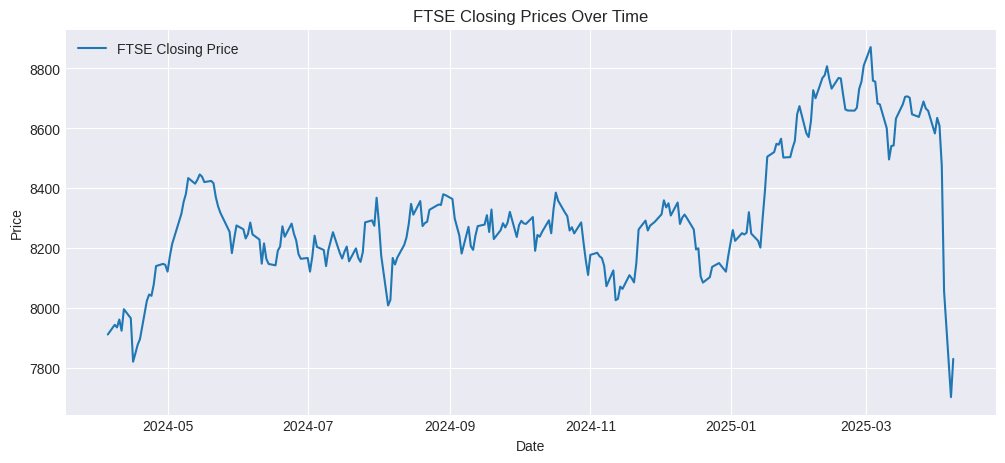

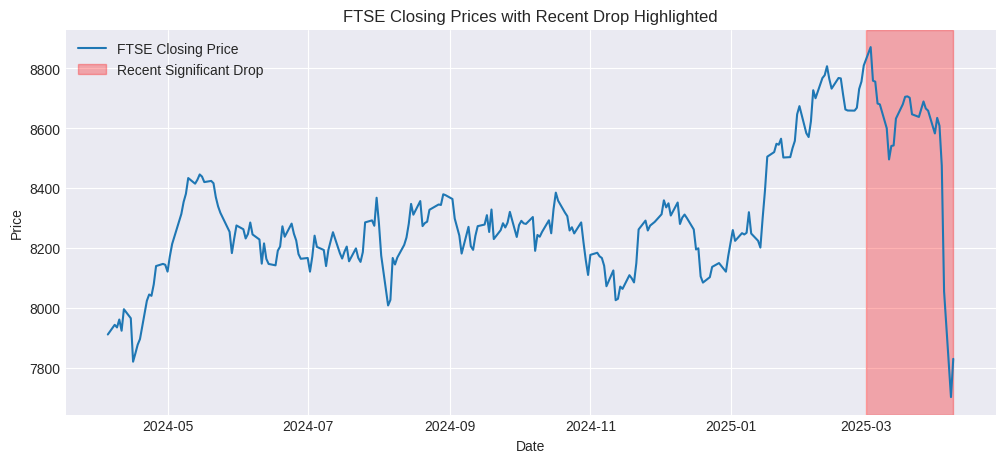

Training set size: 205
Test set size: 52
Test set covers from 2025-01-27 00:00:00+00:00 to 2025-04-07 23:00:00+00:00


In [ ]:
# Plot the original data
plt.figure(figsize=(12, 5))
plt.plot(data.index, close_prices, label='FTSE Closing Price')
plt.title('FTSE Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Highlight recent significant drop
recent_drop_start = pd.to_datetime("2025-03-01").tz_localize('UTC')  # Make sure to use a specific time standard! Otherwise you'll have issues later if times mismatch!
plt.figure(figsize=(12, 5))
plt.plot(data.index, close_prices, label='FTSE Closing Price')
plt.axvspan(pd.to_datetime(recent_drop_start), data.index[-1],
            color='red', alpha=0.3, label='Recent Significant Drop')
plt.title('FTSE Closing Prices with Recent Drop Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 0.8 to 0.2 as is usual
train_size = int(len(close_prices_scaled) * 0.8)
test_size = len(close_prices_scaled) - train_size
train_data, test_data = close_prices_scaled[0:train_size], close_prices_scaled[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Test set covers from {data.index[train_size]} to {data.index[-1]}")

In [ ]:
# Sequence length (time steps to look back)
SEQ_LENGTH = 30

# Create training sequences
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"Training sequences shape: {X_train.shape}")
print(f"Testing sequences shape: {X_test.shape}")

Training sequences shape: (174, 30, 1)
Testing sequences shape: (21, 30, 1)


## Model 1: Autoregressive (AR) Model
Let's start with a traditional AR model as our baseline.

### Important theory

In many time series forecasting problems, models such as the **Autoregressive (AR)** model require the input series to be **stationary**. A stationary time series has statistical properties (mean, variance, and autocorrelation) that do not change over time. Many forecasting methods, statistical tests, and confidence intervals rely on the assumption of stationarity.

### Why Make a Time Series Stationary?

- **Stability:** Stationary series are easier to model because the relationships between past and future values remain consistent over time.
- **Assumption of Models:** Many classical statistical models, including AR and ARIMA, assume stationarity to ensure that their parameters remain constant.

### Differencing

One common method to transform a non-stationary time series into a stationary one is **differencing**. The first-order difference of a time series $X_t$ is defined as:

$$
\Delta X_t = X_t - X_{t-1}
$$

This process helps remove trends and stabilize the mean of the series. For example, if the original series has an upward trend, the differenced series will tend to fluctuate around zero.

### Integration (Reconstruction)

After forecasting the differenced series with the AR model, we need to reconstruct or integrate these predictions back to the original scale. If $\Delta \hat{X}_t$ represents the predicted difference at time $t$, the forecasted level value $\hat{X}_t$ is given by:

$$
\hat{X}_t = X_{t-1} + \Delta \hat{X}_t
$$

Here, $X_{t-1}$ is the last observed value before the prediction, and the integration is performed recursively for each forecasted period.

### Step-by-Step Process Explained

1. **Inverse Transformation:**  
   The scaled training and testing data are first converted back to their original price scales using the inverse transformation of the scaling function (e.g., a MinMax scaler).

2. **Differencing:**  
   We perform a first-order differencing on the training data:
   
   $$
   train_{diff}[t] = raw_{train}[t+1] - raw_{train}[t]
   $$
   
   This helps remove trends and makes the series stationary.

3. **Fitting the AR Model:**  
   An AR model is then fitted on the differenced (stationary) series using a certain number of lags (e.g., SEQ_LENGTH). The model attempts to capture the linear dependency in the stationary series.

4. **Forecasting the Differences:**  
   Using the fitted AR model, forecasts for the differenced series are generated for the test period.

5. **Reconstructing the Level Values (Integration):**  
   Starting with the last known value of the original training series, we iteratively add the predicted differences to reconstruct the forecasted level values:
   
   $$
   \hat{X}_{t+1} = X_{t} + \Delta \hat{X}_{t+1}
   $$
   
   This step transforms the differenced predictions back into the original units (e.g., price levels).

6. **Evaluation and Visualization:**  
   The final step involves comparing the forecasted values with the **actual** observed values on the original scale by computing error metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE), as well as plotting the results to visually inspect the forecast performance.

This comprehensive approach ensures that the AR model is applied to a stationary series—improving its performance and interpretability—while still enabling predictions in the original data scale.


In [ ]:
# At first we will check basic AR approach
# In the next cell we will try AR on stationary data with rolling forecasting (next theory block)

# Check the huge difference in the results

AR(30) Model:
MSE: 67853500.797939
MAE: 8237.025128
RMSE: 8237.323643


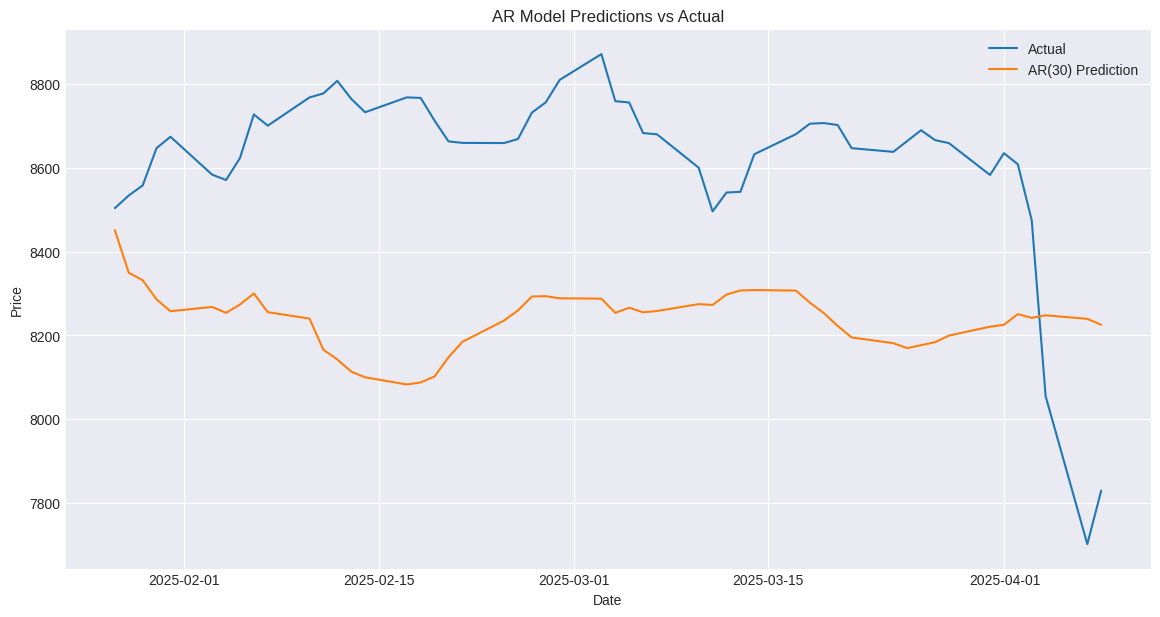

In [ ]:
train_data_flat = scaler.inverse_transform(train_data).reshape(-1)

# Fit AR model
ar_model = AutoReg(train_data_flat, lags=SEQ_LENGTH)
ar_model_fitted = ar_model.fit()

# Make predictions on test data
# Need to use the last SEQ_LENGTH values from training set to start prediction
history = list(train_data_flat[-SEQ_LENGTH:])
predictions = []

for t in range(len(test_data)):
    # Predict next value
    yhat = ar_model_fitted.predict(start=len(train_data_flat)+t, end=len(train_data_flat)+t)
    predictions.append(yhat[0])
    # Update history with true value (simulating real-world prediction)
    history.append(test_data[t][0])

# Calculate metrics
mse_ar = mean_squared_error(test_data, predictions)
mae_ar = mean_absolute_error(test_data, predictions)

print(f"AR({SEQ_LENGTH}) Model:")
print(f"MSE: {mse_ar:.6f}")
print(f"MAE: {mae_ar:.6f}")
print(f"RMSE: {np.sqrt(mse_ar):.6f}")

# Plot predictions
# Plot predictions (corrected)
plt.figure(figsize=(14, 7))

# Use the length of PREDICTIONS, not test_data
plot_dates = data.index[-len(predictions):]  # Get dates corresponding to predictions

plt.plot(plot_dates, scaler.inverse_transform(test_data[-len(predictions):]),
         label='Actual')
plt.plot(plot_dates,
         np.array(predictions).reshape(-1, 1),
         label=f'AR({SEQ_LENGTH}) Prediction')

plt.title('AR Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Rolling AR(30) Model on Differenced (Stationary) Data:
MSE: 11122.273329
MAE: 68.252461
RMSE: 105.462189


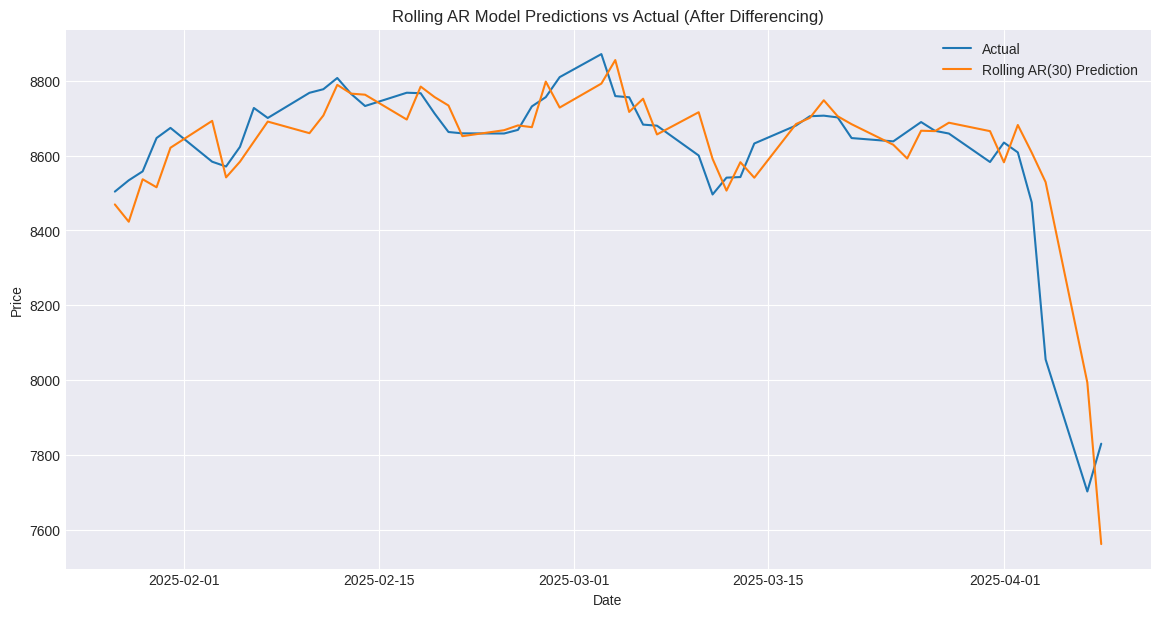

In [ ]:
# First, we convert the data back to its original scale:
raw_train = scaler.inverse_transform(train_data).reshape(-1)
raw_test = scaler.inverse_transform(test_data).reshape(-1)

# --- STEP 1: Transform the training series to a stationary series using first-order differencing ---
# First-order differencing: diff_t = raw_train[t] - raw_train[t-1]
train_diff = np.diff(raw_train, n=1)  # The differenced series, one element shorter than raw_train

# Set the lags parameter (e.g., SEQ_LENGTH)
lags = SEQ_LENGTH

# --- ROLLING FORECAST APPROACH ---
predictions = []  # To store level forecasts

# Convert differenced training data to a list to build our history for the rolling forecast
history_diff = list(train_diff)

# For the integration step, initialize the last known level value from the training series
last_value = raw_train[-1]

# Loop over each step in the test data to perform rolling forecast:
for t in range(len(raw_test)):
    # 1. Fit the AR model on the current history of differenced data
    model = AutoReg(history_diff, lags=lags)
    model_fit = model.fit()

    # 2. Predict the next differenced value (one-step ahead)
    yhat_diff = model_fit.predict(start=len(history_diff), end=len(history_diff))[0]

    # 3. Reconstruct the level forecast by adding the predicted difference to the last known level
    next_value = last_value + yhat_diff
    predictions.append(next_value)

    # 4. Get the actual difference using the observed test value
    # This simulates receiving the true observation in a real-world scenario
    new_diff = raw_test[t] - last_value

    # 5. Update the history with the actual observed difference for the next iteration
    history_diff.append(new_diff)

    # 6. Update the last known level; here we use the actual test value (simulate real-world update)
    last_value = raw_test[t]

# --- STEP 2: Compute error metrics (on the original price scale) ---
mse_ar = mean_squared_error(raw_test, predictions)
mae_ar = mean_absolute_error(raw_test, predictions)

print(f"Rolling AR({lags}) Model on Differenced (Stationary) Data:")
print(f"MSE: {mse_ar:.6f}")
print(f"MAE: {mae_ar:.6f}")
print(f"RMSE: {np.sqrt(mse_ar):.6f}")

# --- STEP 3: Visualize the predictions ---

plt.figure(figsize=(14, 7))
plot_dates = data.index[-len(predictions):]  # Dates corresponding to forecasted points

plt.plot(plot_dates, raw_test, label='Actual')
plt.plot(plot_dates, predictions, label=f'Rolling AR({lags}) Prediction')
plt.title('Rolling AR Model Predictions vs Actual (After Differencing)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Simple RNN
### Theory about Rolling Window Forecast

In a real-world forecasting scenario, we often update our predictions iteratively. This process is called **rolling forecasting** (or **walk-forward validation**). With a rolling window approach, the model generates a forecast for the next time step, then the window is updated with the latest observed value before predicting the next time step. This simulates live forecasting and adapts to new information.

### Rolling Forecast Process

Assume we have a time series $X = \{x_1, x_2, \ldots, x_T\}$ and a forecast horizon $H$. We train our RNN on sequences of length $L$ (the **window size**). For forecasting, we perform the following steps:

1. **Initialization:**
   - Set the initial window using the last $L$ observations from the training set:
$$
W_0 = \{x_{T-L+1}, x_{T-L+2}, \ldots, x_T\}
$$
   
2. **Forecasting Loop:**
   For each forecast step $t = 1, 2, \ldots, H$:
   - Use the current window $W_{t-1}$ as input to the RNN to predict the next value $\hat{x}_{T+t}$:
$$
\hat{x}_{T+t} = f(W_{t-1})
$$
     where f denotes the RNN model.
   - Update the window by removing the oldest observation and appending the new observed value $x_{T+t}$ (if available) or the forecast $\hat{x}_{T+t}$:
$$
W_t = \{W_{t-1}[2:],\, x_{T+t} \text{ (or } \hat{x}_{T+t} \text{)}\}
$$
   
### Forecasting on Stationary Data

When the original time series is non-stationary (i.e., its statistical properties change over time), we often transform it to a stationary series using **first-order differencing**:
$$
\Delta x_t = x_t - x_{t-1}
$$
A model (such as an RNN) can be trained on the differenced series. After predicting the differenced values, the original level forecast is reconstructed by **integration**:
$$
\hat{x}_t = x_{t-1} + \Delta \hat{x}_t
$$

### Summary of Key Formulas in this module

- **First-order Differencing:**
  $$
  \Delta x_t = x_t - x_{t-1}
  $$
  
- **Level Forecast Reconstruction:**
  $$
  \hat{x}_t = x_{t-1} + \Delta \hat{x}_t
  $$
  
- **Rolling Window Update:**
  $$
  W_t = \{W_{t-1}[2:],\, x_{T+t} \text{ (or } \hat{x}_{T+t} \text{)}\}
  $$

This approach ensures that the forecasting model constantly adapts to the latest observations, improving its ability to react to changes in data trends—especially critical in financial or volatile time series.


Epoch [10/100], Loss: 0.002831
Epoch [20/100], Loss: 0.002621
Epoch [30/100], Loss: 0.007005
Epoch [40/100], Loss: 0.004554
Epoch [50/100], Loss: 0.005274
Epoch [60/100], Loss: 0.001949
Epoch [70/100], Loss: 0.001320
Epoch [80/100], Loss: 0.001844
Epoch [90/100], Loss: 0.003049
Epoch [100/100], Loss: 0.001011


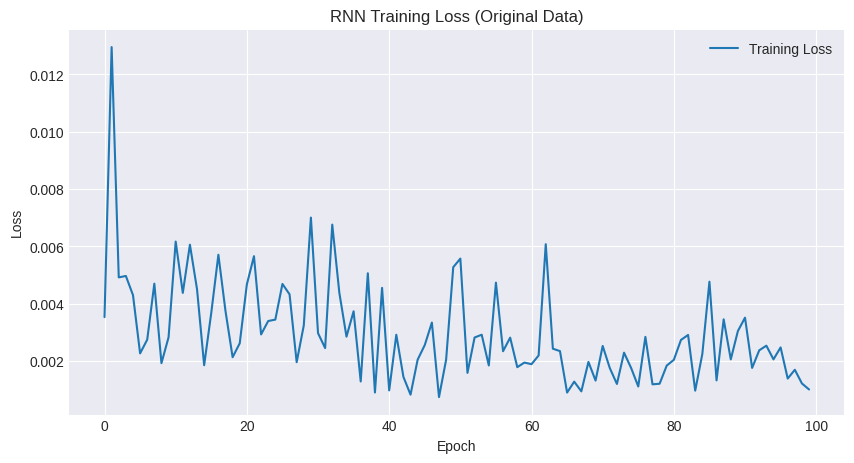

Rolling Forecast RNN (Original Data):
MSE: 16773.168209
MAE: 105.386011
RMSE: 129.511267


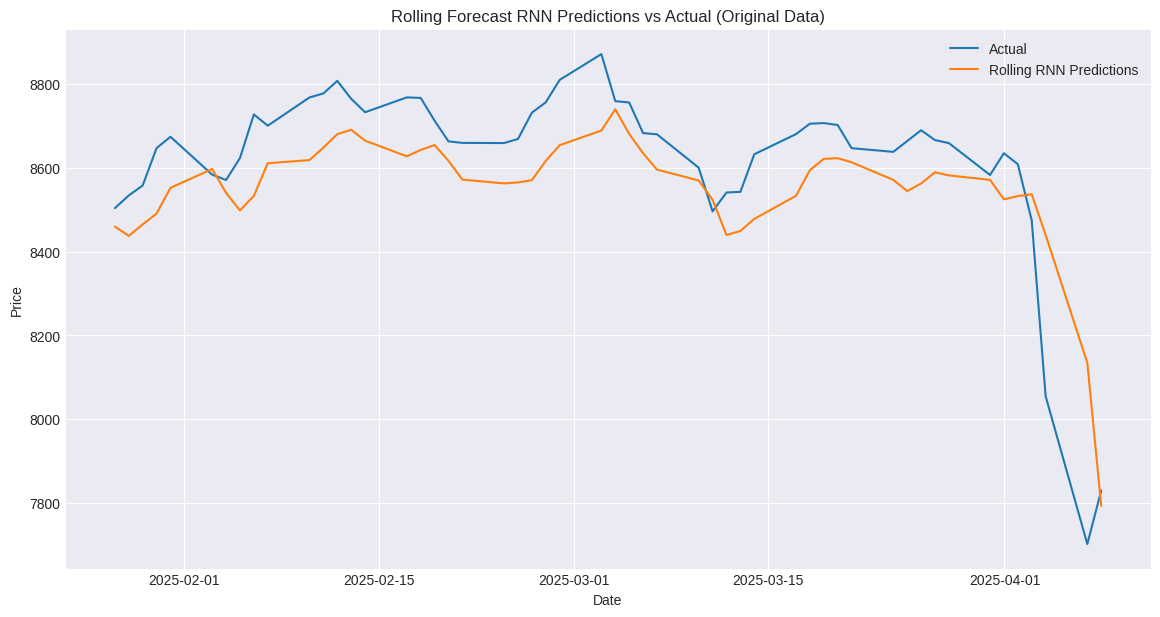

In [ ]:
# --- Define the RNN model ---
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).requires_grad_()
        # Forward pass through RNN
        out, _ = self.rnn(x, h0.detach())
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

# --- Training the RNN on original scaled data ---
rnn_model = RNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

BATCH_SIZE = 16
EPOCHS = 100

# Create DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_losses = []
for epoch in range(EPOCHS):
    rnn_model.train()  # set training mode
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}')

# Plot the training loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training Loss (Original Data)')
plt.legend()
plt.show()

# --- Rolling Forecast on Original Data ---
raw_train = train_data.reshape(-1)
raw_test = test_data.reshape(-1)

# Set the window size (should be equal to SEQ_LENGTH)
window_size = X_train_tensor.shape[1]  # или window_size = SEQ_LENGTH

# Use last 'window_size' points from raw_train as initial seed for the forecast:
current_window = raw_train[-window_size:].copy()
rolling_predictions = []

rnn_model.eval()
with torch.no_grad():
    # Loop over test points to simulate real-time forecasting:
    for t in range(len(raw_test)):
        # Prepare input: reshape -> (batch=1, sequence_length, input_dim=1)
        input_seq = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
        pred = rnn_model(input_seq)
        pred_value = pred.item()
        rolling_predictions.append(pred_value)
        # Update current window with true observed value from raw_test
        true_value = raw_test[t]
        current_window = np.append(current_window[1:], true_value)

# Compute error metrics (on original scale)
rnn_rolling_predictions = scaler.inverse_transform([rolling_predictions])[0]
raw_test = scaler.inverse_transform(test_data).reshape(-1)

mse_rolling = mean_squared_error(raw_test, rnn_rolling_predictions)
mae_rolling = mean_absolute_error(raw_test, rnn_rolling_predictions)
rmse_rolling = np.sqrt(mse_rolling)
print("Rolling Forecast RNN (Original Data):")
print(f"MSE: {mse_rolling:.6f}")
print(f"MAE: {mae_rolling:.6f}")
print(f"RMSE: {rmse_rolling:.6f}")

# Plot predictions vs actual values
plt.figure(figsize=(14,7))
plot_dates = data.index[-len(raw_test):]  # даты для test данных
plt.plot(plot_dates, raw_test, label='Actual')
plt.plot(plot_dates, rnn_rolling_predictions, label='Rolling RNN Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Rolling Forecast RNN Predictions vs Actual (Original Data)')
plt.legend()
plt.show()


## Model 3: LSTM
Finally, let's implement an LSTM model, which is often more effective for time series forecasting.

Epoch [10/100], Loss: 0.003668
Epoch [20/100], Loss: 0.003323
Epoch [30/100], Loss: 0.002328
Epoch [40/100], Loss: 0.002009
Epoch [50/100], Loss: 0.002158
Epoch [60/100], Loss: 0.007299
Epoch [70/100], Loss: 0.001304
Epoch [80/100], Loss: 0.002585
Epoch [90/100], Loss: 0.001328
Epoch [100/100], Loss: 0.001725


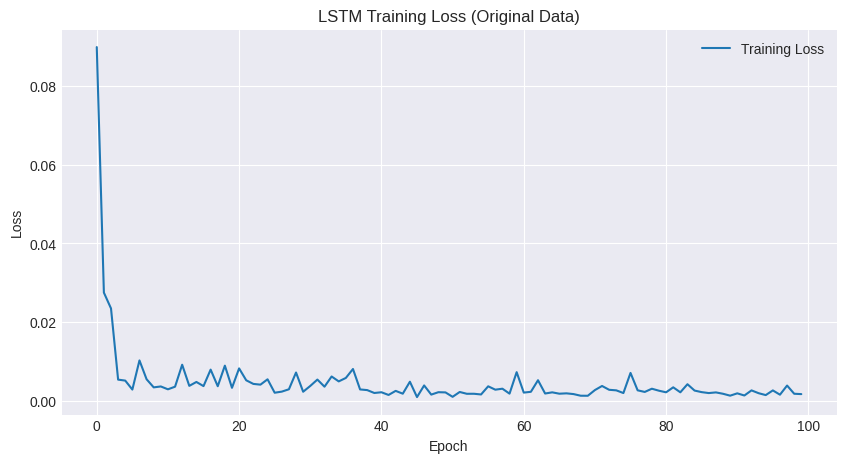

Rolling Forecast LSTM (Original Data):
MSE: 21388.555795
MAE: 123.963263
RMSE: 146.248268


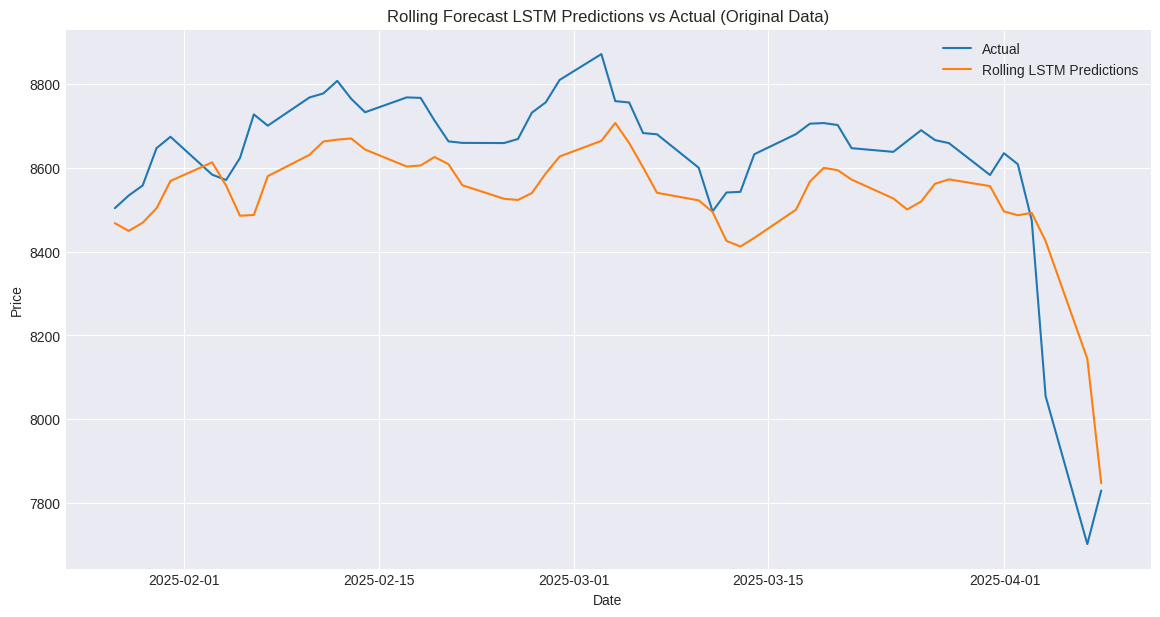

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

# --- Training LSTM on Original (Scaled) Data ---
lstm_model = LSTMModel(num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

BATCH_SIZE = 16
EPOCHS = 100

# Create DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_losses_lstm = []
for epoch in range(EPOCHS):
    lstm_model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    train_losses_lstm.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.6f}')

# Plot training loss
plt.figure(figsize=(10,5))
plt.plot(train_losses_lstm, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss (Original Data)')
plt.legend()
plt.show()

# --- Rolling Forecast on Original Data ---
# Convert the scaled data back to the original scale
raw_train = train_data.reshape(-1)
raw_test = test_data.reshape(-1)


# Set the window size (should be equal to SEQ_LENGTH)
window_size = SEQ_LENGTH  # or window_size = X_train_tensor.shape[1]

# Initialize the window with the last 'window_size' points from raw_train
current_window = raw_train[-window_size:].copy()
rolling_predictions = []

lstm_model.eval()
with torch.no_grad():
    # Loop over the test set to simulate real-time forecasting
    for t in range(len(raw_test)):
        # Prepare the input: reshape to (1, window_size, 1)
        input_seq = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
        pred = lstm_model(input_seq)
        pred_value = pred.item()
        rolling_predictions.append(pred_value)
        # Update the window with the true observed value from raw_test
        true_value = raw_test[t]
        current_window = np.append(current_window[1:], true_value)

# Compute error metrics on the original scale
lstm_rolling_predictions = scaler.inverse_transform([rolling_predictions])[0]
raw_test = scaler.inverse_transform(test_data).reshape(-1)

mse_lstm = mean_squared_error(raw_test, lstm_rolling_predictions)
mae_lstm = mean_absolute_error(raw_test, lstm_rolling_predictions)
rmse_lstm = np.sqrt(mse_lstm)

print("Rolling Forecast LSTM (Original Data):")
print(f"MSE: {mse_lstm:.6f}")
print(f"MAE: {mae_lstm:.6f}")
print(f"RMSE: {rmse_lstm:.6f}")

# Plot predictions vs actual values
plt.figure(figsize=(14,7))
plot_dates = data.index[-len(raw_test):]  # dates corresponding to the test data
plt.plot(plot_dates, raw_test, label='Actual')
plt.plot(plot_dates, lstm_rolling_predictions, label='Rolling LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Rolling Forecast LSTM Predictions vs Actual (Original Data)')
plt.legend()
plt.show()


## Model Comparison and Analysis
Now let's compare all three models and analyze their performance, particularly during the recent significant drop.

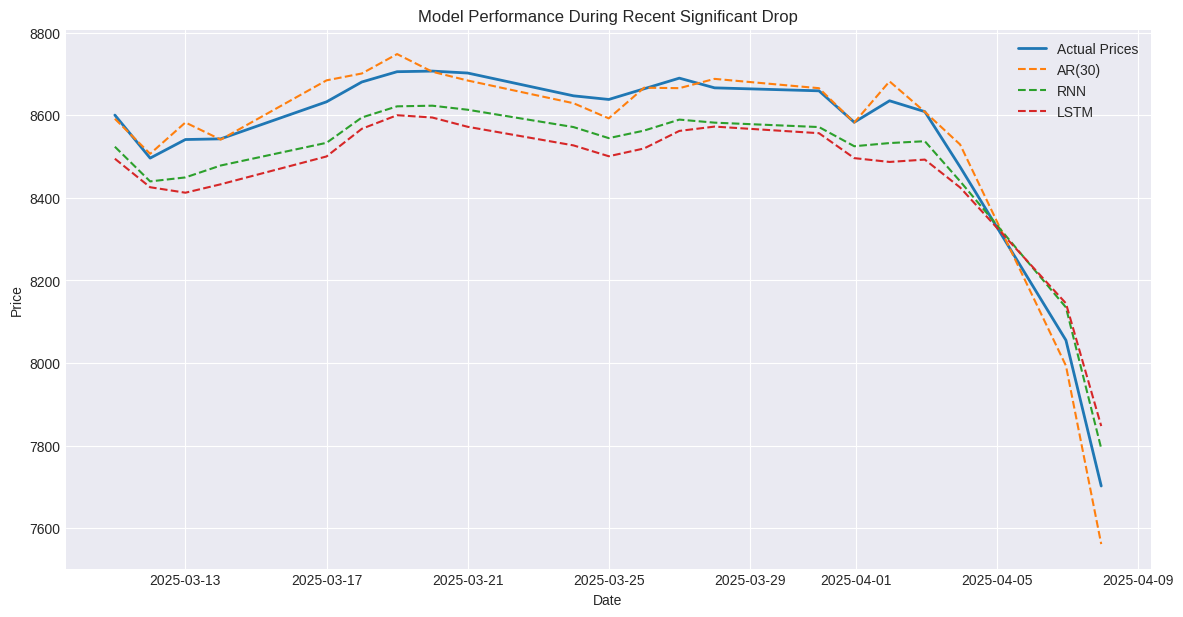


Performance During Recent Drop:
AR(30) - MSE: 1877.3328, MAE: 29.5646
RNN - MSE: 6915.1296, MAE: 81.4839
LSTM - MSE: 13338.5472, MAE: 112.8458


In [ ]:
correct_length = len(y_test)  # Get reference length

actual_prices = scaler.inverse_transform(y_test)
ar_prices = np.array(predictions).reshape(-1, 1)[-correct_length:]    # Trim AR predictions to match correct_length
rnn_prices = np.array(rnn_rolling_predictions)[-correct_length:]      # Trim RNN predictions
lstm_prices = np.array(lstm_rolling_predictions)[-correct_length:]    # Trim LSTM predictions

# Create date range for plotting (aligned to correct_length)
plot_dates = data.index[-correct_length:]

# Zoom in on recent drop (now aligned)
drop_start_idx = np.where(plot_dates >= pd.to_datetime(recent_drop_start))[0][0]

plt.figure(figsize=(14, 7))
plt.plot(plot_dates[drop_start_idx:], actual_prices[drop_start_idx:], label='Actual Prices', linewidth=2)
plt.plot(plot_dates[drop_start_idx:], ar_prices[drop_start_idx:], label=f'AR({SEQ_LENGTH})', linestyle='--')
plt.plot(plot_dates[drop_start_idx:], rnn_prices[drop_start_idx:], label='RNN', linestyle='--')
plt.plot(plot_dates[drop_start_idx:], lstm_prices[drop_start_idx:], label='LSTM', linestyle='--')
plt.title('Model Performance During Recent Significant Drop')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate metrics for the drop period only
drop_actual = actual_prices[drop_start_idx:]
drop_ar = ar_prices[drop_start_idx:]
drop_rnn = rnn_prices[drop_start_idx:]
drop_lstm = lstm_prices[drop_start_idx:]

mse_ar_drop = mean_squared_error(drop_actual, drop_ar)
mae_ar_drop = mean_absolute_error(drop_actual, drop_ar)

mse_rnn_drop = mean_squared_error(drop_actual, drop_rnn)
mae_rnn_drop = mean_absolute_error(drop_actual, drop_rnn)

mse_lstm_drop = mean_squared_error(drop_actual, drop_lstm)
mae_lstm_drop = mean_absolute_error(drop_actual, drop_lstm)

print("\nPerformance During Recent Drop:")
print(f"AR({SEQ_LENGTH}) - MSE: {mse_ar_drop:.4f}, MAE: {mae_ar_drop:.4f}")
print(f"RNN - MSE: {mse_rnn_drop:.4f}, MAE: {mae_rnn_drop:.4f}")
print(f"LSTM - MSE: {mse_lstm_drop:.4f}, MAE: {mae_lstm_drop:.4f}")


## To think about (at home).
1. We mentioned that usually LSTM is showing better then RNN. Can you find the trick, why in this example RNN is showing better and "fix" LSTM? (Hint: you need to change ONE digit in whole code)
2. You can see that AR is showing much better than our RNN and LSTM. Why? Do you remember what we did in AR approach and haven`t done at neural nets approach?

# Module 2: Sequence-to-Sequence Learning for Machine Translation  
**Seminar workflow:**
1. **Data Download and Preparation:**  
   * We use the dataset from [manythings.org/anki](https://www.manythings.org/anki/). In this example – a dataset for Russian-English sentence pairs. But you can choose any other pair of languages in the link above.
   * Tokenization, vocabulary construction, converting sequences into numerical representations, and padding.
2. **Defining Seq2Seq model with RNN, LSTM, GRU modules.**
3. **Model training.**
4. **Perfomance comparison on different splits.**

**Important**:<br>
Training a Seq2Seq model for the MT task is a very labor-intensive process that requires a large amount of data and time. In this seminar, we will build the basic pipeline for each of the models, but run it for only a few epochs to ensure that the loss converges and the model learns.


## Prerequisites

In [ ]:
import urllib.request
import zipfile
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast

import unicodedata
import re
import random
import time
import math
import os
import io

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Seeding
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Using device: cuda


In [ ]:
def download_and_extract_data(url: str, extract_to: str = "./data"):
    """
    Function to download the data archive and extract it.
    :param url: URL of the archive
    :param extract_to: Path to extract the archive contents
    """
    os.makedirs(extract_to, exist_ok=True)
    zip_path = os.path.join(extract_to, "data.zip")

    if not os.path.exists(zip_path):
        print("Downloading data...")
        try:
            # Создаем заголовки, имитирующие браузер
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': '*/*' # Принимаем любой тип контента
            }
            # Создаем объект запроса с URL и заголовками
            req = urllib.request.Request(url, headers=headers)

            # Открываем URL с использованием созданного запроса
            with urllib.request.urlopen(req) as response, open(zip_path, 'wb') as out_file:
                # Копируем содержимое ответа в локальный файл порциями
                shutil.copyfileobj(response, out_file)
            print("Download completed!")
        except urllib.error.HTTPError as e:
            print(f"HTTP Error during download: {e}")
            print(f"URL: {e.url}")
            print(f"Code: {e.code}")
            print(f"Reason: {e.reason}")
            # Опционально: можно прочитать тело ответа, если сервер его прислал
            # error_content = e.read().decode('utf-8', errors='ignore')
            # print(f"Server response: {error_content}")
            return # Выходим, если загрузка не удалась
        except Exception as e:
            print(f"An error occurred during download: {e}")
            return # Выходим, если загрузка не удалась
    else:
        print("Archive already exists.")

    # Extract the archive
    try:
        print(f"Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Data extracted to", extract_to)
    except zipfile.BadZipFile:
        print(f"Error: Failed to unzip file. It might be corrupted or not a zip file.")
        # Попробуем удалить поврежденный файл, чтобы при следующем запуске он скачался заново
        if os.path.exists(zip_path):
             os.remove(zip_path)
             print(f"Removed corrupted file: {zip_path}")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")


In [ ]:
# Data Prep functions
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<sos>": SOS_token, "<eos>": EOS_token, "<pad>": PAD_token, "<unk>": UNK_token}
        self.word2count = {}
        self.index2word = {SOS_token: "<sos>", EOS_token: "<eos>", PAD_token: "<pad>", UNK_token: "<unk>"}
        self.n_words = 4  # Starting with 4 special tokens

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# --- Preprocessing Functions ---
# Convert Unicode to ASCII, removing diacritical marks
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Normalize a string: lowercase, trim whitespace, basic cleaning
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Add a space before punctuation, replace non-letter/digit/punctuation characters with a space
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?'`]+", r" ", s)  # Keep Latin, Cyrillic and basic punctuation
    s = re.sub(r"\s+", r" ", s).strip()  # Remove extra spaces
    return s

# --- Reading and Filtering Data ---
def readLangs(lang1_name, lang2_name, reverse=False):
    print("Reading lines...")
    lines = open(DATA_FILE_PATH, encoding='utf-8').read().strip().split('\n')

    # Split into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]  # Only take the first 2 columns (en, ru)

    # Reverse pairs and create Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2_name)
        output_lang = Lang(lang1_name)
    else:
        input_lang = Lang(lang1_name)
        output_lang = Lang(lang2_name)

    return input_lang, output_lang, pairs

# Filtering pairs by length (and optionally by content for simple examples)
def filterPair(p):
    # p[0] - source (russian), p[1] - target (english)
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# --- Main Data Preparation Function ---
def prepareData(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1_name, lang2_name, reverse)
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs (max_length={MAX_LENGTH})")

    # Limit the number of pairs for speed
    if len(pairs) > MAX_PAIRS:
        pairs = pairs[:MAX_PAIRS]
        print(f"Further reduced to {len(pairs)} pairs for speed.")

    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(f"\t{input_lang.name}: {input_lang.n_words}")
    print(f"\t{output_lang.name}: {output_lang.n_words}")
    return input_lang, output_lang, pairs

# --- Converting Text to Indices ---
def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)  # Append EOS at the end
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)  # [seq_len, 1]

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])  # EOS is already added in tensorFromSentence
    return (input_tensor, target_tensor)

# --- Creating Dataset and Dataloader ---
class TranslationDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        input_tensor, target_tensor = tensorsFromPair(pair)
        return {"input": input_tensor, "target": target_tensor,
                "input_text": pair[0], "target_text": pair[1]}  # For debugging

# --- Function to Split Data ---
# This will be called with different test_size / random_state parameters for comparison
def create_splits(pairs, test_size=0.1, val_size=0.1, random_state=42):
    """Creates train, validation, and test splits."""
    assert test_size + val_size < 1.0
    train_pairs, test_pairs = train_test_split(pairs, test_size=test_size, random_state=random_state)
    # Calculate the validation proportion from the remaining data after separating the test set
    val_proportion = val_size / (1.0 - test_size)
    train_pairs, val_pairs = train_test_split(train_pairs, test_size=val_proportion, random_state=random_state)  # Using the same random_state
    print(f"Data split: Train={len(train_pairs)}, Validation={len(val_pairs)}, Test={len(test_pairs)}")
    return train_pairs, val_pairs, test_pairs

In [ ]:
# Helper function for measuring time per epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


# Function for plotting the loss curves
def plot_losses(train_losses, valid_losses, title='Training and Validation Loss'):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## 1. Data Loading and Preprocessing

* Download the file with Russian-English pairs from [manythings.org/anki](https://www.manythings.org/anki/).
* Unpack the archive.
* Read the data and create a list of pairs (Russian, English).
* Perform preliminary text preprocessing:
    * Unicode normalization (to ensure consistency of characters).
    * Convert to lowercase.
    * Remove unnecessary characters (while keeping basic punctuation).
    * Add a space before punctuation marks (so that they become separate tokens).
    * Add start-of-sequence (`<sos>`) and end-of-sequence (`<eos>`) tokens to the target (English) language.
* Limit the maximum sentence length and vocabulary size to speed up training.
* Create dictionaries (mapping "word -> index" and "index -> word") for both languages, adding special tokens `<pad>` (for padding), `<sos>` (start of sentence), `<eos>` (end of sentence), and `<unk>` (for unknown words).
* Convert text pairs into pairs of index sequences.
* Define a function to create data splits (Train/Validation/Test) to ensure both identical and different splits for comparison tasks.


In [ ]:
# Dataset URL
data_url = "http://www.manythings.org/anki/rus-eng.zip"
download_and_extract_data(data_url)

Download completed!
Extracting ./data/data.zip...
Data extracted to ./data


In [ ]:
SOS_token = 0
EOS_token = 1
PAD_token = 2
UNK_token = 3

DATA_FILE_PATH = "./data/rus.txt"
MAX_LENGTH = 15  # Maximum sentence length (including SOS/EOS)
MAX_PAIRS = 10000  # Limit the dataset for speed (can be increased for better quality)

# Call data preparation (Russian -> English)
input_lang, output_lang, pairs = prepareData('eng', 'rus', reverse=True)  # reverse=True means rus -> eng

# Example pair
print("\nExample pair:")
print(random.choice(pairs))

# Example tensor representation
example_pair_index = random.randrange(len(pairs))
example_tensors = tensorsFromPair(pairs[example_pair_index])
print("\nExample tensors:")
print(f"Source: {pairs[example_pair_index][0]} -> {example_tensors[0].view(-1)}")
print(f"Target: {pairs[example_pair_index][1]} -> {example_tensors[1].view(-1)}")

Reading lines...
Read 496059 sentence pairs
Trimmed to 492209 sentence pairs (max_length=15)
Further reduced to 10000 pairs for speed.
Counting words...
Counted words:
	rus: 4564
	eng: 1740

Example pair:
['я чувствую мне повезет .', 'i feel lucky .']

Example tensors:
Source: сделаи шаг назад . -> tensor([  54, 1354, 1299,    7,    1], device='cuda:0')
Target: step back . -> tensor([512,  99,   5,   1], device='cuda:0')


In [ ]:
# Create the first (primary) split
TRAIN_PAIRS_1, VAL_PAIRS_1, TEST_PAIRS_1 = create_splits(pairs, test_size=0.1, val_size=0.1, random_state=SEED)

# Create datasets for the first split
train_dataset_1 = TranslationDataset(TRAIN_PAIRS_1, input_lang, output_lang)
val_dataset_1 = TranslationDataset(VAL_PAIRS_1, input_lang, output_lang)
test_dataset_1 = TranslationDataset(TEST_PAIRS_1, input_lang, output_lang)

# DataLoader
BATCH_SIZE = 1 # For simplicity of your realisation for this seminar we use Batch Size = 1

train_iterator_1 = DataLoader(train_dataset_1, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_1 = DataLoader(val_dataset_1, batch_size=BATCH_SIZE, shuffle=False)
test_iterator_1 = DataLoader(test_dataset_1, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nCreated DataLoaders for Split 1 with Batch Size = {BATCH_SIZE}")


Data split: Train=7999, Validation=1001, Test=1000

Created DataLoaders for Split 1 with Batch Size = 1


## 2. Defining the Seq2Seq Model

The model consists of two main components:
* **Encoder:** Accepts the input sequence (a sentence in the source language) and converts it into a context vector (the hidden state of the recurrent network). We implement the encoder so that it can use RNN, LSTM, or GRU.
* **Decoder:** Accepts the context vector from the encoder and the `<sos>` token, then generates the output sequence (a sentence in the target language) token by token. At each step, it uses the previous hidden state and the predicted token to generate the next one. We also make it flexible to use RNN, LSTM, or GRU.
* **Seq2Seq Model:** A wrapper that connects the encoder and the decoder. It implements the "Teacher Forcing" mechanism to accelerate convergence during training.

**RNN Architectures:**
* **Simple RNN:** The simplest recurrent network, which suffers from the vanishing/exploding gradient problem on long sequences.
* **LSTM (Long Short-Term Memory):** Contains special gates (forget, input, output) to control the flow of information, allowing it to better capture long-term dependencies.
* **GRU (Gated Recurrent Unit):** A simplified version of LSTM with fewer gates (update and reset), often showing comparable performance with lower computational complexity.


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type='GRU', dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_type = rnn_type.upper()

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        # batch_first=False because tensors are [seq_len, batch_size=1, features]
        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=False)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=False)
        elif self.rnn_type == 'RNN':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=False)
        else:
            raise ValueError("Unsupported RNN type. Choose 'LSTM', 'GRU', or 'RNN'.")

    def forward(self, input_seq):
        # input_seq: [seq_len, batch_size=1]
        embedded = self.dropout(self.embedding(input_seq))  # embedded: [seq_len, 1, hidden_size]

        # LSTM returns outputs, (hidden, cell)
        # GRU/RNN return outputs, hidden
        outputs, hidden = self.rnn(embedded)
        # outputs: [seq_len, 1, hidden_size]
        # hidden (and cell for LSTM): [num_layers*num_directions=1, 1, hidden_size]

        return outputs, hidden  # Return all outputs and the last hidden state

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type='GRU', dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn_type = rnn_type.upper()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        if self.rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=False)
        elif self.rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=False)
        elif self.rnn_type == 'RNN':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=False)
        else:
            raise ValueError("Unsupported RNN type. Choose 'LSTM', 'GRU', or 'RNN'.")

        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, decoder_input, decoder_hidden):
        # decoder_input: [batch_size=1] - one token at a time
        # decoder_hidden: ([1, 1, hidden_size], [1, 1, hidden_size]) for LSTM
        #                 [1, 1, hidden_size] for GRU/RNN

        if decoder_input.dim() == 1:
            decoder_input = decoder_input.unsqueeze(1)  # [1, 1]

        embedded = self.dropout(self.embedding(decoder_input))  # embedded: [1, 1, hidden_size]

        # LSTM expects (hidden, cell)
        # GRU/RNN expect hidden
        rnn_output, hidden = self.rnn(embedded, decoder_hidden)
        # rnn_output: [1, 1, hidden_size]
        # hidden: same as decoder_hidden

        # Remove the seq_len=1 dimension before the Linear layer
        output = self.out(rnn_output.squeeze(0))  # output: [1, output_size]

        return output, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.3):
        # src: [src_len, batch_size=1]
        # trg: [trg_len, batch_size=1]
        # teacher_forcing_ratio: probability of using the actual token as the next input
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_size

        # Tensor for storing decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # The last hidden state of the encoder is used as the initial hidden state for the decoder
        encoder_outputs, encoder_hidden = self.encoder(src)

        # The first input for the decoder is the <sos> token
        decoder_input = trg[0, :]

        # Initial hidden state for the decoder (for LSTM, this will be a tuple (hidden, cell))
        decoder_hidden = encoder_hidden

        for t in range(1, trg_len):  # Start from 1, since the 0th input is <sos>
            # Run the decoder for one time step
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # Save the prediction
            outputs[t] = decoder_output

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the token with the highest probability
            top1 = decoder_output.argmax(1)

            # If teacher forcing, the next input is the actual token, otherwise the predicted token
            decoder_input = trg[t] if teacher_force else top1

        # outputs: [trg_len, batch_size=1, trg_vocab_size]
        return outputs


## 3. Model Training
* Implement the function `train_epoch` for one epoch of training:
* Implement the function `evaluate` for validation/test evaluation:
* Implement the main function `train`, which:
    * Runs the epoch loop.
    * Calls `train_epoch` and `evaluate`.
* Define hyperparameters:
  *   hidden layer size = 128
  *   number of epochs = 5-10 (1 epoch ~ 1min)
  *   learning rate = 0.0005
* Initialize the model (choosing the RNN type), the optimizer (Adam), and the loss function (CrossEntropyLoss, since this is a classification task at each decoder step). PyTorch's `CrossEntropyLoss` expects model outputs of shape `(N, C)` or `(N, C, d_1, ..., d_k)` and targets of shape `(N)` or `(N, d_1, ..., d_k)`, where `C` is the number of classes. You may need to adjust the tensor shapes slightly before feeding them to the loss function. Losses on `<pad>` tokens should be ignored.



In [ ]:
def train_epoch(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio, scaler):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch['input'].to(device)
        trg = batch['target'].to(device)
        src = src.squeeze(0)  # Ensure squeeze is maintained
        trg = trg.squeeze(0)  # Ensure squeeze is maintained

        optimizer.zero_grad()

        # Use autocast for mixed precision
        with autocast(enabled=torch.cuda.is_available()):  # Enable only if CUDA is available
            outputs = model(src, trg, teacher_forcing_ratio)  # [trg_len, batch_size=1, output_dim]
            output_dim = outputs.shape[-1]
            outputs_reshaped = outputs[1:].view(-1, output_dim)  # Skip the <sos> token
            trg_reshaped = trg[1:].view(-1)  # Skip the <sos> token
            loss = criterion(outputs_reshaped, trg_reshaped)

        # Scale the loss and perform backward
        scaler.scale(loss).backward()

        # Instead of the normal optimizer step:
        scaler.step(optimizer)
        scaler.update()  # Update scaler for the next iteration

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Eval function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch['input'].to(device)
            trg = batch['target'].to(device)

            src = src.squeeze(0)
            trg = trg.squeeze(0)

            # Turn off teacher forcing for evaluation
            outputs = model(src, trg, 0)  # outputs: [trg_len, batch_size, output_dim]

            output_dim = outputs.shape[-1]

            # Skip the <sos> token and reshape
            outputs_reshaped = outputs[1:].view(-1, output_dim)
            trg_reshaped = trg[1:].view(-1)

            loss = criterion(outputs_reshaped, trg_reshaped)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Main training function
def train_model(model, train_iterator, valid_iterator, optimizer, criterion, n_epochs, clip, model_save_path, teacher_forcing_ratio=0.5):
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    # Create a GradScaler ONLY ONCE before the training loop
    scaler = GradScaler(enabled=torch.cuda.is_available())  # Enable only if CUDA is available

    print(f"Starting training for {n_epochs} epochs...")
    print(f"Mixed precision enabled: {scaler.is_enabled()}")  # Display status

    for epoch in range(n_epochs):
        start_time = time.time()

        # Pass scaler into train_epoch
        train_loss = train_epoch(model, train_iterator, optimizer, criterion, clip, teacher_forcing_ratio, scaler)
        valid_loss = evaluate(model, valid_iterator, criterion)  # evaluate can remain without scaler

        end_time = time.time()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"\t-- Best validation loss improved. Model saved to {model_save_path} --")

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # Plot the loss curve after training is complete
    plot_losses(train_losses, valid_losses, title=f'{model.encoder.rnn_type} Model Loss')

    return train_losses, valid_losses  # Return the loss history



===== Training RNN Model on Split_1 =====
Starting training for 5 epochs...
Mixed precision enabled: False


<ipython-input-27-82debf67d4e5>:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())  # Enable only if CUDA is available
<ipython-input-27-82debf67d4e5>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):  # Enable only if CUDA is available


	-- Best validation loss improved. Model saved to seq2seq-rnn-Split_1.pt --
Epoch: 01 | Time: 6m 15s
	Train Loss: 3.020 | Train PPL:  20.490
	 Val. Loss: 2.768 |  Val. PPL:  15.926
	-- Best validation loss improved. Model saved to seq2seq-rnn-Split_1.pt --
Epoch: 02 | Time: 5m 46s
	Train Loss: 2.378 | Train PPL:  10.783
	 Val. Loss: 2.430 |  Val. PPL:  11.362
	-- Best validation loss improved. Model saved to seq2seq-rnn-Split_1.pt --
Epoch: 03 | Time: 5m 21s
	Train Loss: 2.073 | Train PPL:   7.951
	 Val. Loss: 2.270 |  Val. PPL:   9.682
	-- Best validation loss improved. Model saved to seq2seq-rnn-Split_1.pt --
Epoch: 04 | Time: 5m 19s
	Train Loss: 1.858 | Train PPL:   6.408
	 Val. Loss: 2.098 |  Val. PPL:   8.148
	-- Best validation loss improved. Model saved to seq2seq-rnn-Split_1.pt --
Epoch: 05 | Time: 5m 28s
	Train Loss: 1.683 | Train PPL:   5.379
	 Val. Loss: 2.008 |  Val. PPL:   7.449


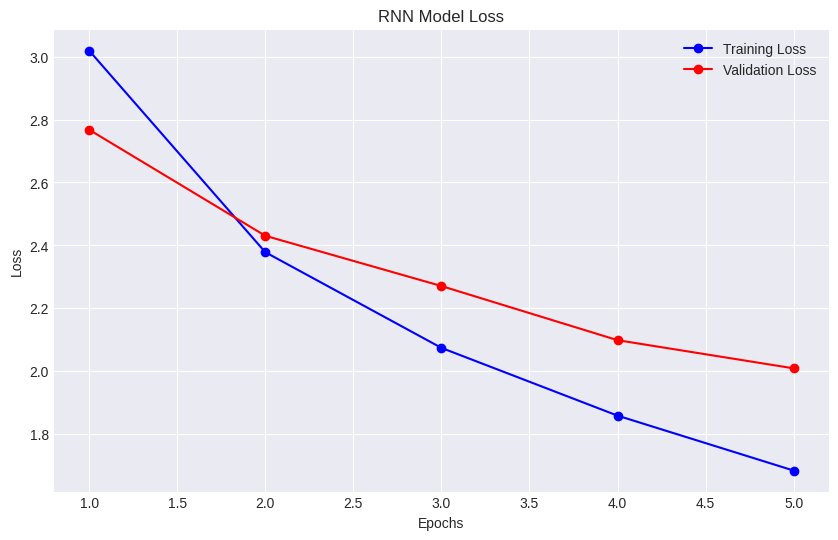


--- RNN Final Results on Split_1 ---
	Best Validation Loss: 2.008 | Best Val. PPL:   7.449
	Test Loss: 2.093 | Test PPL:   8.106

===== Training LSTM Model on Split_1 =====
Starting training for 5 epochs...
Mixed precision enabled: False
	-- Best validation loss improved. Model saved to seq2seq-lstm-Split_1.pt --
Epoch: 01 | Time: 5m 57s
	Train Loss: 3.155 | Train PPL:  23.458
	 Val. Loss: 2.888 |  Val. PPL:  17.954
	-- Best validation loss improved. Model saved to seq2seq-lstm-Split_1.pt --
Epoch: 02 | Time: 5m 36s
	Train Loss: 2.529 | Train PPL:  12.535
	 Val. Loss: 2.527 |  Val. PPL:  12.522
	-- Best validation loss improved. Model saved to seq2seq-lstm-Split_1.pt --
Epoch: 03 | Time: 5m 6s
	Train Loss: 2.222 | Train PPL:   9.229
	 Val. Loss: 2.330 |  Val. PPL:  10.280
	-- Best validation loss improved. Model saved to seq2seq-lstm-Split_1.pt --
Epoch: 04 | Time: 5m 11s
	Train Loss: 1.993 | Train PPL:   7.341
	 Val. Loss: 2.206 |  Val. PPL:   9.077
	-- Best validation loss improved.

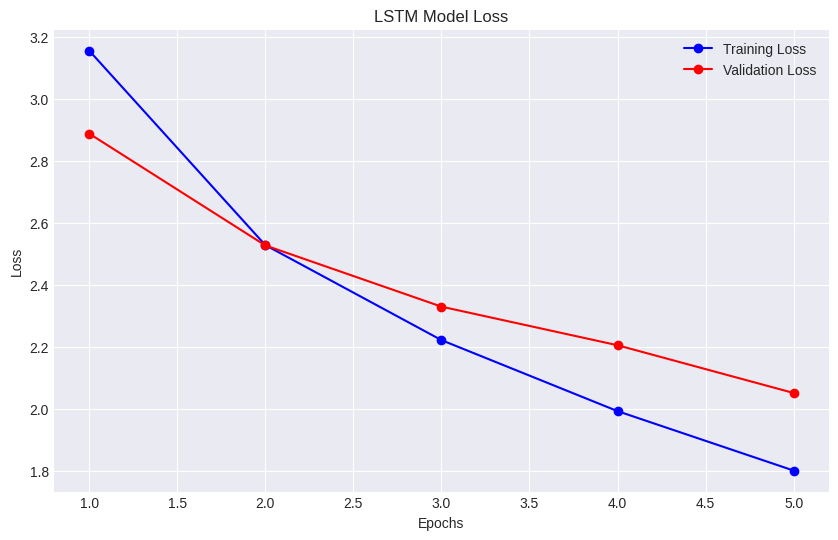


--- LSTM Final Results on Split_1 ---
	Best Validation Loss: 2.052 | Best Val. PPL:   7.783
	Test Loss: 2.034 | Test PPL:   7.644

===== Training GRU Model on Split_1 =====
Starting training for 5 epochs...
Mixed precision enabled: False
	-- Best validation loss improved. Model saved to seq2seq-gru-Split_1.pt --
Epoch: 01 | Time: 5m 48s
	Train Loss: 3.125 | Train PPL:  22.762
	 Val. Loss: 2.901 |  Val. PPL:  18.196
	-- Best validation loss improved. Model saved to seq2seq-gru-Split_1.pt --
Epoch: 02 | Time: 5m 27s
	Train Loss: 2.474 | Train PPL:  11.865
	 Val. Loss: 2.492 |  Val. PPL:  12.080
	-- Best validation loss improved. Model saved to seq2seq-gru-Split_1.pt --
Epoch: 03 | Time: 4m 56s
	Train Loss: 2.123 | Train PPL:   8.358
	 Val. Loss: 2.291 |  Val. PPL:   9.884
	-- Best validation loss improved. Model saved to seq2seq-gru-Split_1.pt --
Epoch: 04 | Time: 5m 0s
	Train Loss: 1.876 | Train PPL:   6.530
	 Val. Loss: 2.106 |  Val. PPL:   8.214
	-- Best validation loss improved. Mod

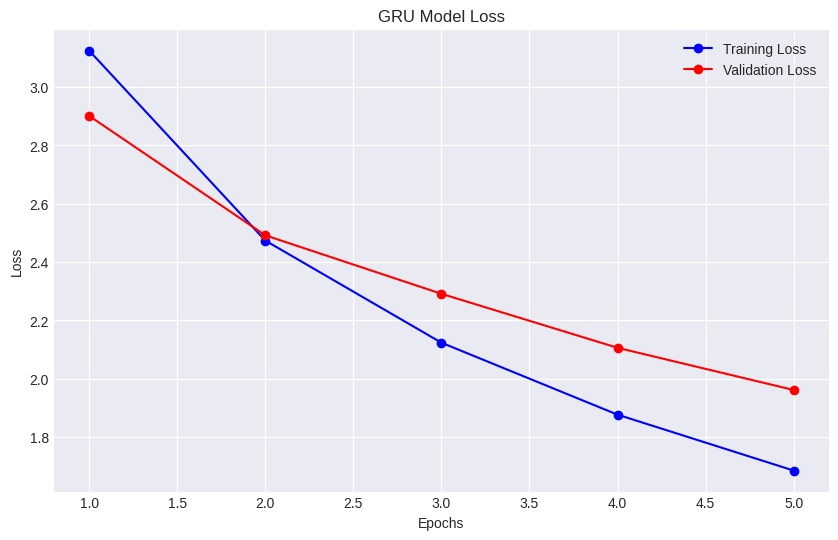


--- GRU Final Results on Split_1 ---
	Best Validation Loss: 1.961 | Best Val. PPL:   7.107
	Test Loss: 2.014 | Test PPL:   7.493


In [ ]:
# --- Hyperparameters ---
HIDDEN_DIM = 128  # Hidden dimension (and embedding size for simplicity)
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.0005
N_EPOCHS = 5   # Increase for better quality, but training will take longer
CLIP = 1
TEACHER_FORCING_RATIO = 0.5  # Start with 0.5; can be decreased over time (annealing)

INPUT_DIM = input_lang.n_words
OUTPUT_DIM = output_lang.n_words

# --- Dictionaries for storing results ---
results = {}
trained_models = {}

# --- Training models---
data_split_name = "Split_1"
split_iterators = {'train': train_iterator_1, 'valid': valid_iterator_1, 'test': test_iterator_1}

for rnn_type in ['RNN', 'LSTM', 'GRU']:
    print(f"\n===== Training {rnn_type} Model on {data_split_name} =====")

    # --- Model Initialization ---
    encoder = EncoderRNN(INPUT_DIM, HIDDEN_DIM, rnn_type=rnn_type, dropout_p=ENC_DROPOUT)
    decoder = DecoderRNN(HIDDEN_DIM, OUTPUT_DIM, rnn_type=rnn_type, dropout_p=DEC_DROPOUT)
    model = Seq2Seq(encoder, decoder, device).to(device)

    # Weight initialization (can help with convergence)
    def init_weights(m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Added weight_decay
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    model_save_path = f'seq2seq-{rnn_type.lower()}-{data_split_name}.pt'

    # --- Training ---
    train_losses, valid_losses = train_model(
        model,
        split_iterators['train'],
        split_iterators['valid'],
        optimizer,
        criterion,
        N_EPOCHS,
        CLIP,
        model_save_path,
        TEACHER_FORCING_RATIO
    )

    # --- Loading the best model and evaluating on the test set ---
    model.load_state_dict(torch.load(model_save_path))
    test_loss = evaluate(model, split_iterators['test'], criterion)

    print(f'\n--- {rnn_type} Final Results on {data_split_name} ---')
    print(f'\tBest Validation Loss: {min(valid_losses):.3f} | Best Val. PPL: {math.exp(min(valid_losses)):7.3f}')
    print(f'\tTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

    # Saving results
    results[(rnn_type, data_split_name)] = {
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_valid_loss': min(valid_losses),
        'test_loss': test_loss,
        'model_path': model_save_path
    }
    trained_models[(rnn_type, data_split_name)] = model  # Save the model itself (or just the state_dict)

In [ ]:
print("\n===== Comparison of Architectures on Split 1 =====")
for rnn_type in ['RNN', 'LSTM', 'GRU']:
    key = (rnn_type, data_split_name)
    if key in results:
        print(f"--- {rnn_type} ---")
        print(f"\tBest Val Loss: {results[key]['best_valid_loss']:.4f}")
        print(f"\tTest Loss:     {results[key]['test_loss']:.4f}")
        print(f"\tTest PPL:      {math.exp(results[key]['test_loss']):.4f}")


===== Comparison of Architectures on Split 1 =====
--- RNN ---
	Best Val Loss: 2.0081
	Test Loss:     2.0926
	Test PPL:      8.1061
--- LSTM ---
	Best Val Loss: 2.0519
	Test Loss:     2.0339
	Test PPL:      7.6440
--- GRU ---
	Best Val Loss: 1.9611
	Test Loss:     2.0140
	Test PPL:      7.4929


### To think about (at home).
1) We used some hacks to not overfit RNN, can you "break" the model so it will be overfitting? (Hint: it can be done by changing just few parameters)<br>
2) Try to increase amount of data and check the time for LSTM and GRU.<br>
3) What do you think will happen with losses and PPL if we train 30 epochs for each model? Which model will be more stable on "long run"? Which model will have smallest PPL?<br>

## 5. Comparison of Performance on Different Splits

* Choose one of the architectures (for example, RNN).
* Use the training results of this model on the **first** split (already obtained above).
* Create a **second** data split (`train_pairs_2`, `val_pairs_2`, `test_pairs_2`) with different proportions or with another `random_state`.
* Create new `DataLoader` instances for the second split.
* Initialize a **new** RNN model with the same hyperparameters.
* Train this new model on the **second** data split.
* Compare the results (validation/test loss) of the RNN model trained on the first split with the results of the RNN model trained on the second split.


In [ ]:
# --- Choose model for comparison ---
chosen_rnn_type = 'RNN'

# --- Creating the second data split ---
print("\n===== Creating Second Data Split =====")
TRAIN_PAIRS_2, VAL_PAIRS_2, TEST_PAIRS_2 = create_splits(pairs, test_size=0.1, val_size=0.1, random_state=SEED + 1)  # Different random_state

# Create datasets and iterators for the second split
train_dataset_2 = TranslationDataset(TRAIN_PAIRS_2, input_lang, output_lang)
val_dataset_2 = TranslationDataset(VAL_PAIRS_2, input_lang, output_lang)
test_dataset_2 = TranslationDataset(TEST_PAIRS_2, input_lang, output_lang)

train_iterator_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator_2 = DataLoader(val_dataset_2, batch_size=BATCH_SIZE, shuffle=False)
test_iterator_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE, shuffle=False)

print(f"Created DataLoaders for Split 2 with Batch Size = {BATCH_SIZE}")

# --- Training the chosen model on Split 2 ---
data_split_name_2 = "Split_2"
split_iterators_2 = {'train': train_iterator_2, 'valid': valid_iterator_2, 'test': test_iterator_2}

print(f"\n===== Training {chosen_rnn_type} Model on {data_split_name_2} =====")

# --- Initializing a NEW model ---
# Important: do not reuse the model trained on the first split!
encoder_2 = EncoderRNN(INPUT_DIM, HIDDEN_DIM, rnn_type=chosen_rnn_type, dropout_p=ENC_DROPOUT)
decoder_2 = DecoderRNN(HIDDEN_DIM, OUTPUT_DIM, rnn_type=chosen_rnn_type, dropout_p=DEC_DROPOUT)
model_2 = Seq2Seq(encoder_2, decoder_2, device).to(device)
model_2.apply(init_weights)

optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
criterion_2 = nn.CrossEntropyLoss(ignore_index=PAD_token)

model_save_path_2 = f'seq2seq-{chosen_rnn_type.lower()}-{data_split_name_2}.pt'

# --- Training ---
train_losses_2, valid_losses_2 = train_model(
    model_2,
    split_iterators_2['train'],
    split_iterators_2['valid'],
    optimizer_2,
    criterion_2,
    N_EPOCHS,
    CLIP,
    model_save_path_2,
    TEACHER_FORCING_RATIO
)

# --- Loading the best model and evaluating on the test set ---
model_2.load_state_dict(torch.load(model_save_path_2))
test_loss_2 = evaluate(model_2, split_iterators_2['test'], criterion_2)

print(f'\n--- {chosen_rnn_type} Final Results on {data_split_name_2} ---')
print(f'\tBest Validation Loss: {min(valid_losses_2):.3f} | Best Val. PPL: {math.exp(min(valid_losses_2)):7.3f}')
print(f'\tTest Loss: {test_loss_2:.3f} | Test PPL: {math.exp(test_loss_2):7.3f}')

# Save the results
results[(chosen_rnn_type, data_split_name_2)] = {
    'train_losses': train_losses_2,
    'valid_losses': valid_losses_2,
    'best_valid_loss': min(valid_losses_2),
    'test_loss': test_loss_2,
    'model_path': model_save_path_2
}
trained_models[(chosen_rnn_type, data_split_name_2)] = model_2

# --- Comparison of results for the chosen model on different splits ---
print(f"\n===== Comparison for {chosen_rnn_type} Model on Different Splits =====")
key1 = (chosen_rnn_type, "Split_1")
key2 = (chosen_rnn_type, "Split_2")

if key1 in results:
    print(f"--- Results on Split 1 (e.g., 80/10/10, seed={SEED}) ---")
    print(f"\tBest Val Loss: {results[key1]['best_valid_loss']:.4f}")
    print(f"\tTest Loss:     {results[key1]['test_loss']:.4f}")
    print(f"\tTest PPL:      {math.exp(results[key1]['test_loss']):.4f}")
else:
    print(f"Results for {key1} not found.")

if key2 in results:
    print(f"--- Results on Split 2 (e.g., 80/10/10, seed={SEED+1}) ---")
    print(f"\tBest Val Loss: {results[key2]['best_valid_loss']:.4f}")
    print(f"\tTest Loss:     {results[key2]['test_loss']:.4f}")
    print(f"\tTest PPL:      {math.exp(results[key2]['test_loss']):.4f}")
else:
    print(f"Results for {key2} not found.")

### To think about (at home).
1. We can see much larger gap between train and val loss at the end? Why? Will be other models more stable?
2. Try the same cell, but change split proportions.
3. How can you stabilize RNN training process?

# Module 3: Machine Translation with Transformers
**Seminar workflow:**
1. **Data**  
   We will use the same data as in Module 2.
2. **Load the pretrained model.**
3. **Estimate the zero-shot model performance.**
3. **Model training.**
4. **Perfomance comparison.**

**Important**:<br>
For the demonstration purposes, in this part we will use the model that has good initial quality and will try to improve it. With this setup, you will be able to see changes in a couple of training epochs. In real applications, you will likely need to choose another model / dataset / training procedure, etc.


In [ ]:
%pip install transformers datasets evaluate sacrebleu >> None

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
def compute_bleu_score(eval_preds):
    bleu_score = evaluate.load("sacrebleu")
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = bleu_score.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
def print_translation_examples(model):
    sample_idx = [2, 4, 12, 14, 15, 32, 49]
    ru_examples = dataset_val[sample_idx]['ru']
    en_examples = dataset_val[sample_idx]['en']
    for i, (en_text, ru_text) in enumerate(zip(en_examples, ru_examples)):
        inputs = tokenizer(en_text, return_tensors="pt").input_ids.to(device)
        outputs = model.generate(inputs, max_new_tokens=128, do_sample=False)
        gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print ('Example {}'.format(i+1))
        print ('EN text:')
        print (en_text)
        print ('RU text:')
        print (ru_text)
        print ('Generated text:')
        print (gen_text)
        print ()

In [ ]:
MAX_LENGTH = 128

We will use TRAIN_PAIRS_1 and VAL_PAIRS_1 for train and validation respectively. First, let us convert them to Datasets.

In [ ]:
dataset_train = Dataset.from_dict({'ru': [pair[0] for pair in TRAIN_PAIRS_1],
                                   'en': [pair[1] for pair in TRAIN_PAIRS_1]})
dataset_val = Dataset.from_dict({'ru': [pair[0] for pair in VAL_PAIRS_1],
                                 'en': [pair[1] for pair in VAL_PAIRS_1]})

Second, write a function which would tokenize the 'ru' and 'en' texts.

In [ ]:
def preprocess_function(examples):
    inputs = [ex for ex in examples["en"]]
    targets = [ex for ex in examples["ru"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=MAX_LENGTH, truncation=True
    )
    return model_inputs

Load the tokenizer

In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-ru"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Transform the datasets using preprocess_function.

In [ ]:
tokenized_dataset_train = dataset_train.map(preprocess_function, batched=True)
tokenized_dataset_val = dataset_val.map(preprocess_function, batched=True)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Load the model.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Set the hyperparameters

In [ ]:
LR = 5e-4
BATCH_SIZE = 16
WEIGHT_DECAY = 0.02
NUM_EPOCHS = 10

In [ ]:
training_args = Seq2SeqTrainingArguments(
    report_to="none",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_EPOCHS,
    predict_with_generate=True,
    fp16=True,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_bleu_score,
)

<ipython-input-36-95d4a8eb987b>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Evaluate model quality before training

In [ ]:
trainer.evaluate(max_length=MAX_LENGTH)

{'eval_loss': 2.2166481018066406,
 'eval_model_preparation_time': 0.0052,
 'eval_bleu': 14.60515203554055,
 'eval_runtime': 25.0613,
 'eval_samples_per_second': 39.942,
 'eval_steps_per_second': 2.514}

Explore some examples of wrong translations

In [ ]:
print_translation_examples(model)

Example 1
EN text:
beat it .
RU text:
катись отсюда .
Generated text:
Попробуй.

Example 2
EN text:
is it to go ?
RU text:
вам с собои ?
Generated text:
Может, пойдёшь?

Example 3
EN text:
get in line .
RU text:
заимите очередь .
Generated text:
Идите в линию.

Example 4
EN text:
pick him up .
RU text:
подвези его .
Generated text:
Поднимите его.

Example 5
EN text:
tom is gone .
RU text:
том ушел .
Generated text:
Тома больше нет.

Example 6
EN text:
hurry back .
RU text:
вернись поскорее .
Generated text:
Быстрее назад.

Example 7
EN text:
love hurts .
RU text:
любовь зла .
Generated text:
Любовь болит.



In [ ]:
trainer.train()

Step,Training Loss
500,1.560700
1000,1.088200
1500,0.834100
2000,0.669200
2500,0.532000
3000,0.438900
3500,0.362800
4000,0.289500
4500,0.234800
5000,0.181900


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=5000, training_loss=0.6192036346435547, metrics={'train_runtime': 552.3618, 'train_samples_per_second': 144.814, 'train_steps_per_second': 9.052, 'total_flos': 179121343758336.0, 'train_loss': 0.6192036346435547, 'epoch': 10.0})

Evaluate the model quality after training. Could you achieve a better BLEU score?

In [ ]:
trainer.evaluate(max_length=MAX_LENGTH)

{'eval_loss': 1.1888599395751953,
 'eval_model_preparation_time': 0.0052,
 'eval_bleu': 26.66146192496927,
 'eval_runtime': 19.0382,
 'eval_samples_per_second': 52.578,
 'eval_steps_per_second': 3.309,
 'epoch': 10.0}

Explore translations of trained model for the same examples. Do you see an improvement?

In [ ]:
print_translation_examples(model)

Example 1
EN text:
beat it .
RU text:
катись отсюда .
Generated text:
убираися .

Example 2
EN text:
is it to go ?
RU text:
вам с собои ?
Generated text:
это поидет ?

Example 3
EN text:
get in line .
RU text:
заимите очередь .
Generated text:
заими очередь .

Example 4
EN text:
pick him up .
RU text:
подвези его .
Generated text:
подбери его .

Example 5
EN text:
tom is gone .
RU text:
том ушел .
Generated text:
тома нет .

Example 6
EN text:
hurry back .
RU text:
вернись поскорее .
Generated text:
вернитесь поскоре .

Example 7
EN text:
love hurts .
RU text:
любовь зла .
Generated text:
любовь причиняет боль .



# Module 4: Problems
**Seminar workflow:**
1. **Find the derivative of softmax**
2. **Find the derivative of cross-entropy.**

**Part 1: Derivative of softmax**

Consider the softmax funstion:

$$S(x_{i}) = \frac{e^{x_i}}{\sum_{k=1}^K e^{x_k}} \;\;\;\text{ for } i = 1, \dots, K$$

Softmax takes a $K$-dimensional vector as input and outputs $K$-dimensional vector $S(x): \mathbb{R}^{K} \rightarrow \mathbb{R}^{K}$:
$$S(x): \begin{bmatrix}x_{1} \\ x_{2}\\ \vdots \\x_{K} \end{bmatrix} \rightarrow \begin{bmatrix}S_{1} \\ S_{2}\\ \vdots \\S_{K}\end{bmatrix}$$

Thus, the derivative of softmax function is Jacobian matrix:
$$\frac{\partial S}{\partial x} =
\begin{bmatrix}
\frac{\partial S_{1}}{\partial x_{1}} & \frac{\partial S_{1}}{\partial x_{2}} & \cdots & \frac{\partial S_{1}}{\partial x_{K}} \\
\frac{\partial S_{2}}{\partial x_{1}} & \frac{\partial S_{2}}{\partial x_{2}} & \cdots & \frac{\partial S_{2}}{\partial x_{K}} \\
\vdots & \vdots & \cdots & \vdots \\
\frac{\partial S_{K}}{\partial x_{1}} & \frac{\partial S_{K}}{\partial x_{2}} & \cdots & \frac{\partial S_{K}}{\partial x_{K}} \\
\end{bmatrix}
$$

Let us compute $\frac{\partial S_{i}}{\partial x_{j}}$ for some $i, j$:

$$\frac{\partial S_{i}}{\partial x_{j}} = \dfrac{\partial}{\partial x_{j}}\frac{e^{x_{i}}}{\sum_{k=1}^{K} e^{x_k}}$$

Represent the function as quotient $f(x) = \dfrac{g(x)}{h(x)}$ and use the formula to compute derivate:

$$f^{'}(x) = \frac{g^{'}(x)h(x) - h^{'}(x)g(x)}{\left[h(x) \right]^{2}}$$

Define $g_{i} = e^{x_{i}}$ and $h_{i} = \sum_{k=1}^{K} e^{x_k}$.

Compute the derivative of $h_i$:
$$\frac{\partial}{\partial x_{j}} h_{i} = \frac{\partial}{\partial x_{j}} \sum_{k=1}^{K} e^{x_k} = \sum_{k=1}^{K}  \frac{\partial}{\partial x_{j}} e^{x_k} = e^{x_{j}}$$

Compute the derivative of $g_i$:
$$\frac{\partial}{\partial x_j}g_i = \frac{\partial}{\partial x_j} e^{x_i} = e^{x_i}[i = j]$$

Put it all together for $i = j$:

$$\begin{split}
\dfrac{\partial \frac{e^{x_{i}}}{\sum_{k=1}^{K} e^{x_k}} }{\partial x_{j}} &= \frac{e^{x_{i}} \sum_{k=1}^{K} e^{x_k}- e^{x_{j}}e^{x_{i}}}{\left[\sum_{k=1}^{K} e^{x_k} \right]^{2}}\\
&=\frac{e^{x_{i}}\left(\sum_{k=1}^{K} e^{x_k} - e^{x_{j}}\right)}{\left[\sum_{k=1}^{K} e^{x_k} \right]^{2}}\\
&=S_{i} (1-S_{j})
\end{split}$$

Put it all together for $i \neq j$:

\begin{split}
\dfrac{\partial \frac{e^{x_{i}}}{\sum_{k=1}^{K} e^{x_k}} }{\partial x_{j}} &= \frac{0 \sum_{k=1}^{K} e^{x_k}- e^{x_{j}}e^{x_{i}}}{\left[\sum_{k=1}^{K} e^{x_k} \right]^{2}}\\
&=-\frac{e^{x_{j}}}{\sum_{k=1}^{K} e^{x_k}} \frac{e^{x_{i}}}{\sum_{k=1}^{K} e^{x_k}}\\
&=-S_{j}S_{i}
\end{split}

Recall that $S_i = \frac{e^{x_i}}{\sum_{k=1}^K e^{x_k}}$, we obtain:

$\frac{\partial S_{i}}{\partial x_{j}}$ = \begin{cases}
         S_{i} (1-S_{j}) & \mbox{if $i = j$}\\
        -S_{j}S_{i} & \mbox{if $i \neq j$}\end{cases}

**Part 2: Derivative of Cross-Entropy Loss**

Multi-class cross-entropy is given by:

$$L = - \frac{1}{N} \sum_{n=1}^{N}  \sum_{j=1}^{K} \left[y_{nj} \log (p_{nj}) \right],$$

and for one instance:

$$l = - \sum_{j}^{K} \left[y_{j} \log (p_{j}) \right],$$

where $p_{j} = \text{softmax}(o_{j})$, $o_j$ - logit.

Compute the loss derivative w.r.t. logits. (Hint: split the sum into two sums for $i=j$ and $i \neq j$)
$$\begin{split}
\frac{\partial}{\partial o_{i}} l &= - \sum_{j=i}y_{j} \frac{\partial \log (p_{j})}{\partial o_{i}} - \sum_{j \neq i}y_{j}\frac{\partial \log (p_{j})}{\partial o_{i}}\\
&= - \sum_{j=i}y_{j} \frac{1}{p_{j}}\frac{\partial p_{j}}{\partial o_{i}} - \sum_{j \neq i}y_{j}\frac{1}{p_{j}}\frac{\partial p_{j}}{\partial o_{i}}\\
&= - y_{i} \frac{1}{p_{j}} p_{j}(1-p_{i}) - \sum_{j \neq i}y_{j}\frac{1}{p_{j}}(-p_{j}p_{i})\\
& = - y_{i} (1- p_{i}) - \sum_{j \neq i}y_{j}\frac{1}{p_{j}}(-p_{j}p_{i})\\
&=- y_{i} + \underbrace{y_{i}p_{i} + \sum_{j \neq i}y_{j}p_{i}}_{ \bigstar } \\
&= p_{i}\left(\sum_{j}y_{j} \right) - y_{i} = p_{i} - y_{i}
\end{split}$$